In [101]:
# using Distributed
# using SharedArrays
# addprocs(2);

In [102]:
@everywhere include("inverse_prob.jl")
@everywhere include("code/barycenter.jl")

In [111]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;
x = range(0,step=h,length=Nx)
y = range(0,step=h,length=Ny)
    
Fs = 500;
dt = 1/Fs
Nt = 1501;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
source_position = zeros(11,2)
for i = 1:11
    source_position[i,:] = [5 10*(i-1)+1]
#     source_position[i,:] = [5 51]
end
source = repeat(source, 1, 11)

receiver_position = zeros(51,2)
for i = 1:51
    receiver_position[i,:] = [101, (i-1)*2+1]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)
# c[50:end,:] .= 1.1
# c[30:40,30:60] .= 1.05
# c[60:80,60:80] .= 1.15
# c[30:50,20:40] .= 1.05
# c = imfilter(c, Kernel.gaussian(10));
    
c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[50:70,60:80] .= 1.05
for i = 1:Nx
    for j = 1:Ny
        if sqrt((x[i]-0.5).^2 + (y[j]-0.5).^2) < 0.2
            c0[i,j] = 1.05
        end
    end
end
            
    
# c = imfilter(c0, Kernel.gaussian(20));

cc = ones(Nx, Ny)
rhoc = ones(Nx, Ny)

pml_len = 20
pml_coef = 50
end

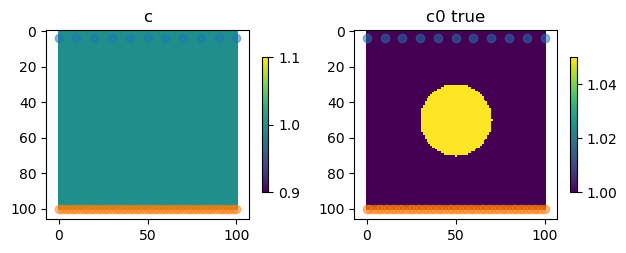

In [112]:
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0 true")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [113]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

# @time datac, uc = multi_solver_parallel(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);


 55.257930 seconds (1.11 k allocations: 50.688 KiB)
 54.969023 seconds (1.05 k allocations: 45.484 KiB)


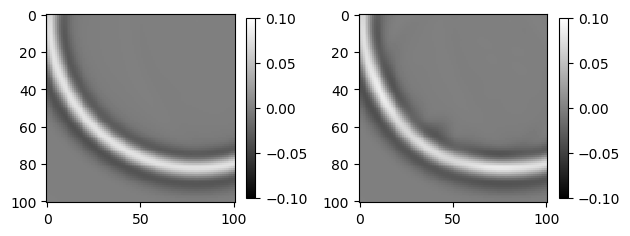

In [6]:
figure;
subplot(121); imshow(u[:,:,500,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

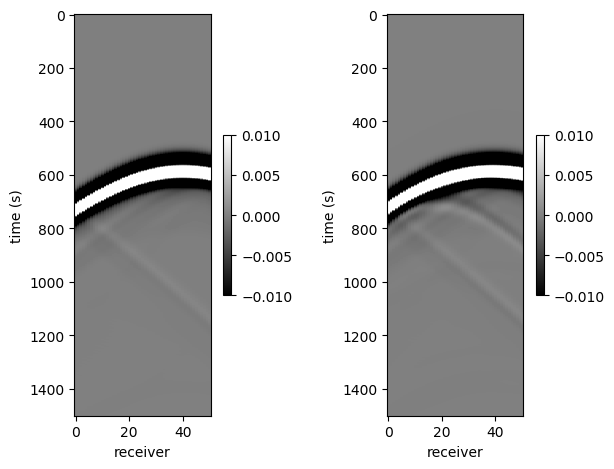

In [7]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [8]:
# mi1 = minimum(data-datac)
# mi2 = minimum(data0-datac)
# mi = abs(min(mi1,mi2))
# M = cost_matrix_1d(t, t; p=2)
# @time adj_s, dd = adj_source_sinkhorn_parallel(data-datac, data0-datac, M; reg_p=0, reg=5e-3, reg_m=1e2, iterMax=100, verbose=false);

# figure;
# r_axis = 0:21
# subplot(121); imshow(-adj_s[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); 
# # clim([0.03,0.04])
# xlabel("receiver"); ylabel("time (s)")
# subplot(122); imshow(data0[:,:,2]-data[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
# xlabel("receiver"); ylabel("time (s)")
# tight_layout()

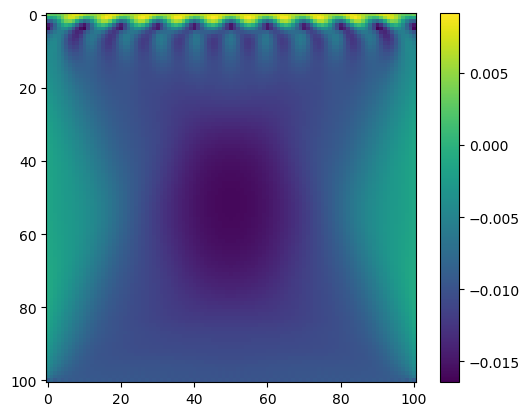

198.921166 seconds (3.04 k allocations: 12.567 GiB, 2.52% gc time)


PyObject <matplotlib.colorbar.Colorbar object at 0x1263ecf10>

In [114]:
@time gg, dd = grad_sinkhorn_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position;reg_p=0, pml_len=10, pml_coef=100, reg=5e-3, reg_m=1e2, iterMax=50, verbose=false);
imshow(gg); colorbar()

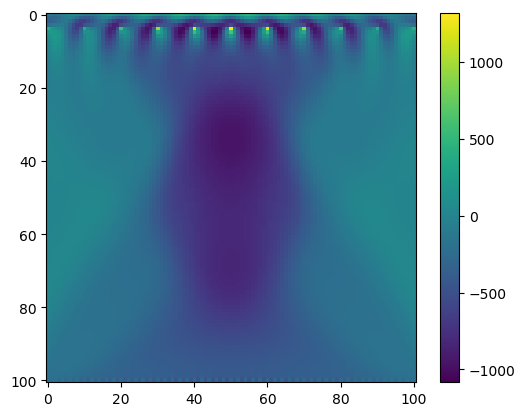

174.087940 seconds (6.28 M allocations: 185.438 GiB, 18.93% gc time)


PyObject <matplotlib.colorbar.Colorbar object at 0x12645abd0>

In [115]:
@time ggl = grad_l2(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
imshow(ggl); colorbar()

In [9]:
# function f_l2_parallel(data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
#     c = reshape(c, Nx, Ny)
#     data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)
#     misfit = 0.5 * norm(data-data0,2)^2 * dt * h^2
#     return misfit
# end

# function g_l2_parallel(data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
#     c = reshape(c, Nx, Ny)
#     data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)
    
#     adj_source = data-data0
    
#     vl = backward_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
    
#     uu = 0 .* u;
#     uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
#     gradl = uu[:,:,end:-1:1,:].*vl
#     gradl = sum(gradl, dims=[3,4])
#     gradl = gradl[:,:,1,1]
    
#     gradl .= gradl / maximum(abs.(gradl))
    
#     return gradl[:]
# end

g_l2_parallel (generic function with 1 method)

In [14]:
# f_l2_parallel(data0, initial_x, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100)

2.709618324510753e-7

In [79]:
# lower = zeros(Nx,Ny)
# lower = lower[:]
# upper = 2*ones(Nx,Ny)
# upper = upper[:]

# initial_x = c[:]

# inner_optimizer = GradientDescent(alphaguess = InitialStatic(alpha=0.01), linesearch = BackTracking())


# ff_l2(x) = f_l2_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100)
# gg_l2(x) = g_l2_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);

# results = optimize(ff_l2, gg_l2, lower, upper, initial_x, Fminbox(inner_optimizer), inplace = false, Optim.Options(g_tol = 1e-12,
#                  iterations = 1,
#                  store_trace = true,
#                  show_trace = true))

In [104]:
# opt_fn(x) = obj_fn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100)
opt_fn(x) = obj_fn_sinkhorn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100, reg=5e-3, reg_m=1e2, reg_p=0, iterMax=100, verbose=false)

opt_fn (generic function with 1 method)

In [105]:
x0 = c[:]
xk, fn_value = gradient_descent(opt_fn, x0, 0.01, 1, 1, 1.05; rho=0.5, c=1e-4, maxSearchTime=1, threshold=1e-5)

Main iteration: 1
Start line search. fk: 4.71139e+04
    alpha: 1.00000e-02    fk1: 4.71139e+04    fk-c*alpha*gradk^2: 4.71139e+04
    alpha: 5.00000e-03    fk1: 4.71139e+04    fk-c*alpha*gradk^2: 4.71139e+04
Line search failed. Search time: 1. Try to decrease search coef c.
----------------------------------------------------------------
Line search Failed. Try decrease line search coef alpha. Interupt.
----------------------------------------------------------------


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [47113.874825000785, 0.0])

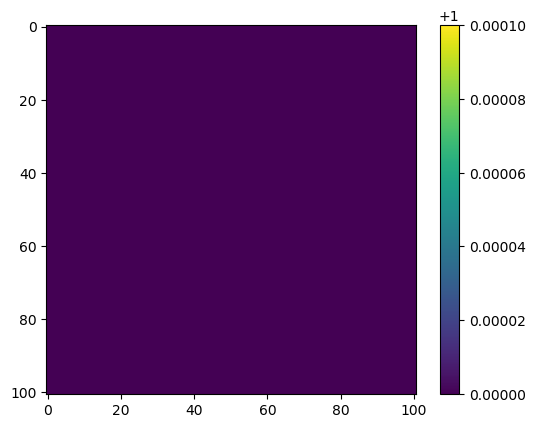

In [106]:
imshow(reshape(xk,Nx,Ny)); colorbar(); clim([1,1.0001])

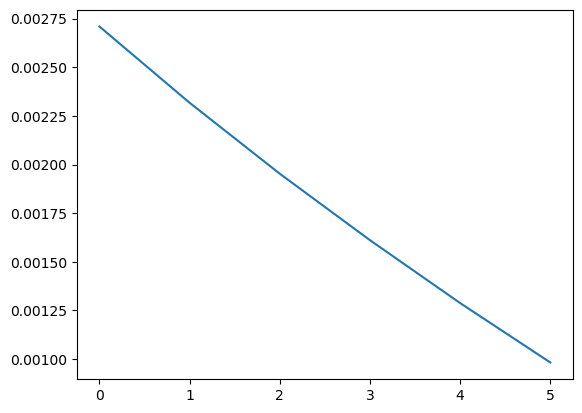

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x161715610>

In [23]:
plot(fn_value)

In [67]:
using MAT

In [116]:
matwrite("example1.mat", Dict("xx" => xk,"ff" => fn_value,"c"=>c,"c0"=>c0); compress = false)